# Lab: Regularizing MLPs

------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this lab, you'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

PRÁCTICA 2. PARTE 2

DIEGO COLLADO MARTÍN - NIA: 100405606 

DIEGO LÓPEZ LÓPEZ - NIA: 100507210

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

# Representamos un conjunto de imágenes del dataset
Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)
# Observamos como representan ropa. Zapatos, camisetas, jerseys...

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping and dropout.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Lets take a look to the mini-batch size and plot a sample.

In [5]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

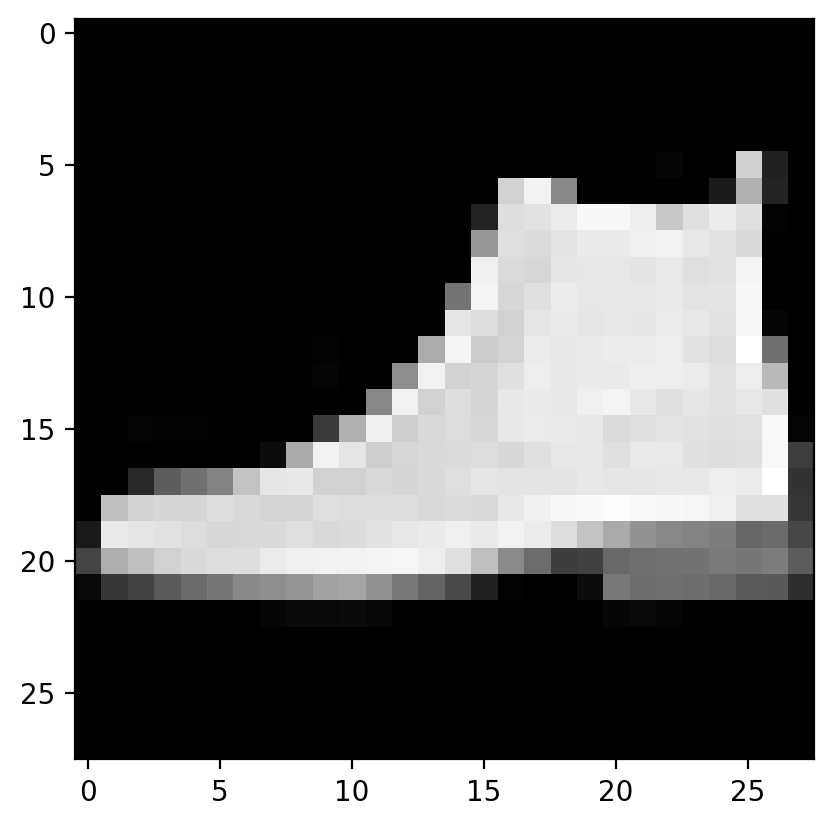

In [6]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [7]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)

        self.output4 = nn.Linear(hidden3, nlabels) # Como nos piden 4 capas, añadimos una nueva respecto al MLP de la práctica anterior
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x) # A la salida se le aplica la logsoftmax para la clasificación multiclase
        return x

In [8]:
class MLP_extended(MLP):
    # Todo es igual que el regresor logístico multiclase pero añadiendo el número de las neuronas de las capas ocultas
    # Añadimos la dimensión de la capa extra con la que contamos
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
    def trainloop(self,trainloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
        
    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [9]:
#YOUR CODE HERE

my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=0.001 )
my_MLP.trainloop(trainloader)

Training loss after 0 epochs: 0.531186
Training loss after 1 epochs: 0.379401
Training loss after 2 epochs: 0.338979
Training loss after 3 epochs: 0.314455
Training loss after 4 epochs: 0.294180
Training loss after 5 epochs: 0.276951
Training loss after 6 epochs: 0.261274
Training loss after 7 epochs: 0.250388
Training loss after 8 epochs: 0.239500
Training loss after 9 epochs: 0.234204
Training loss after 10 epochs: 0.219542
Training loss after 11 epochs: 0.211792
Training loss after 12 epochs: 0.201382
Training loss after 13 epochs: 0.193911
Training loss after 14 epochs: 0.183446
Training loss after 15 epochs: 0.177289
Training loss after 16 epochs: 0.175356
Training loss after 17 epochs: 0.164098
Training loss after 18 epochs: 0.157811
Training loss after 19 epochs: 0.153819
Training loss after 20 epochs: 0.145008
Training loss after 21 epochs: 0.137481
Training loss after 22 epochs: 0.137158
Training loss after 23 epochs: 0.127677
Training loss after 24 epochs: 0.127322
Training l

In [10]:
# Obtenemos el accuracy de entrenamiento y test

acurracy_train_MLP = my_MLP.acurracy_study(trainloader,my_MLP)
acurracy_test_MLP = my_MLP.acurracy_study(testloader,my_MLP)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.9621702
El acurracy en el set de test es: 0.88126993


In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [11]:
import copy

# Del conjunto de entrenamiento, llevaremos 45k imágenes al propio entrenamiento y 15k al conjunto de validación

validloader = copy.deepcopy(trainloader)  # Copiamos

# We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000] # primeras 45k para entrenamiento

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:] # resto (15k) para validación



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [12]:
#YOUR CODE HERE

class MLP_extended(MLP):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # loss en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): #no calculamos grads
                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))#testeamos con el set de val
                    validation_loss += self.criterion(out_val, labels_val)
               

                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) 

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) 
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [13]:
#YOUR CODE HERE
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=30, lr=0.001 )
my_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.554432
Validation loss after 0 epochs: 0.417037

Training loss after 1 epochs: 0.394464
Validation loss after 1 epochs: 0.403067

Training loss after 2 epochs: 0.350515
Validation loss after 2 epochs: 0.357133

Training loss after 3 epochs: 0.321473
Validation loss after 3 epochs: 0.361386

Training loss after 4 epochs: 0.304187
Validation loss after 4 epochs: 0.336997

Training loss after 5 epochs: 0.289199
Validation loss after 5 epochs: 0.330082

Training loss after 6 epochs: 0.270526
Validation loss after 6 epochs: 0.327710

Training loss after 7 epochs: 0.259096
Validation loss after 7 epochs: 0.344159

Training loss after 8 epochs: 0.246737
Validation loss after 8 epochs: 0.335858

Training loss after 9 epochs: 0.230748
Validation loss after 9 epochs: 0.333585

Training loss after 10 epochs: 0.223183
Validation loss after 10 epochs: 0.338700

Training loss after 11 epochs: 0.211335
Validation loss after 11 epochs: 0.317660

Training loss after 12 e

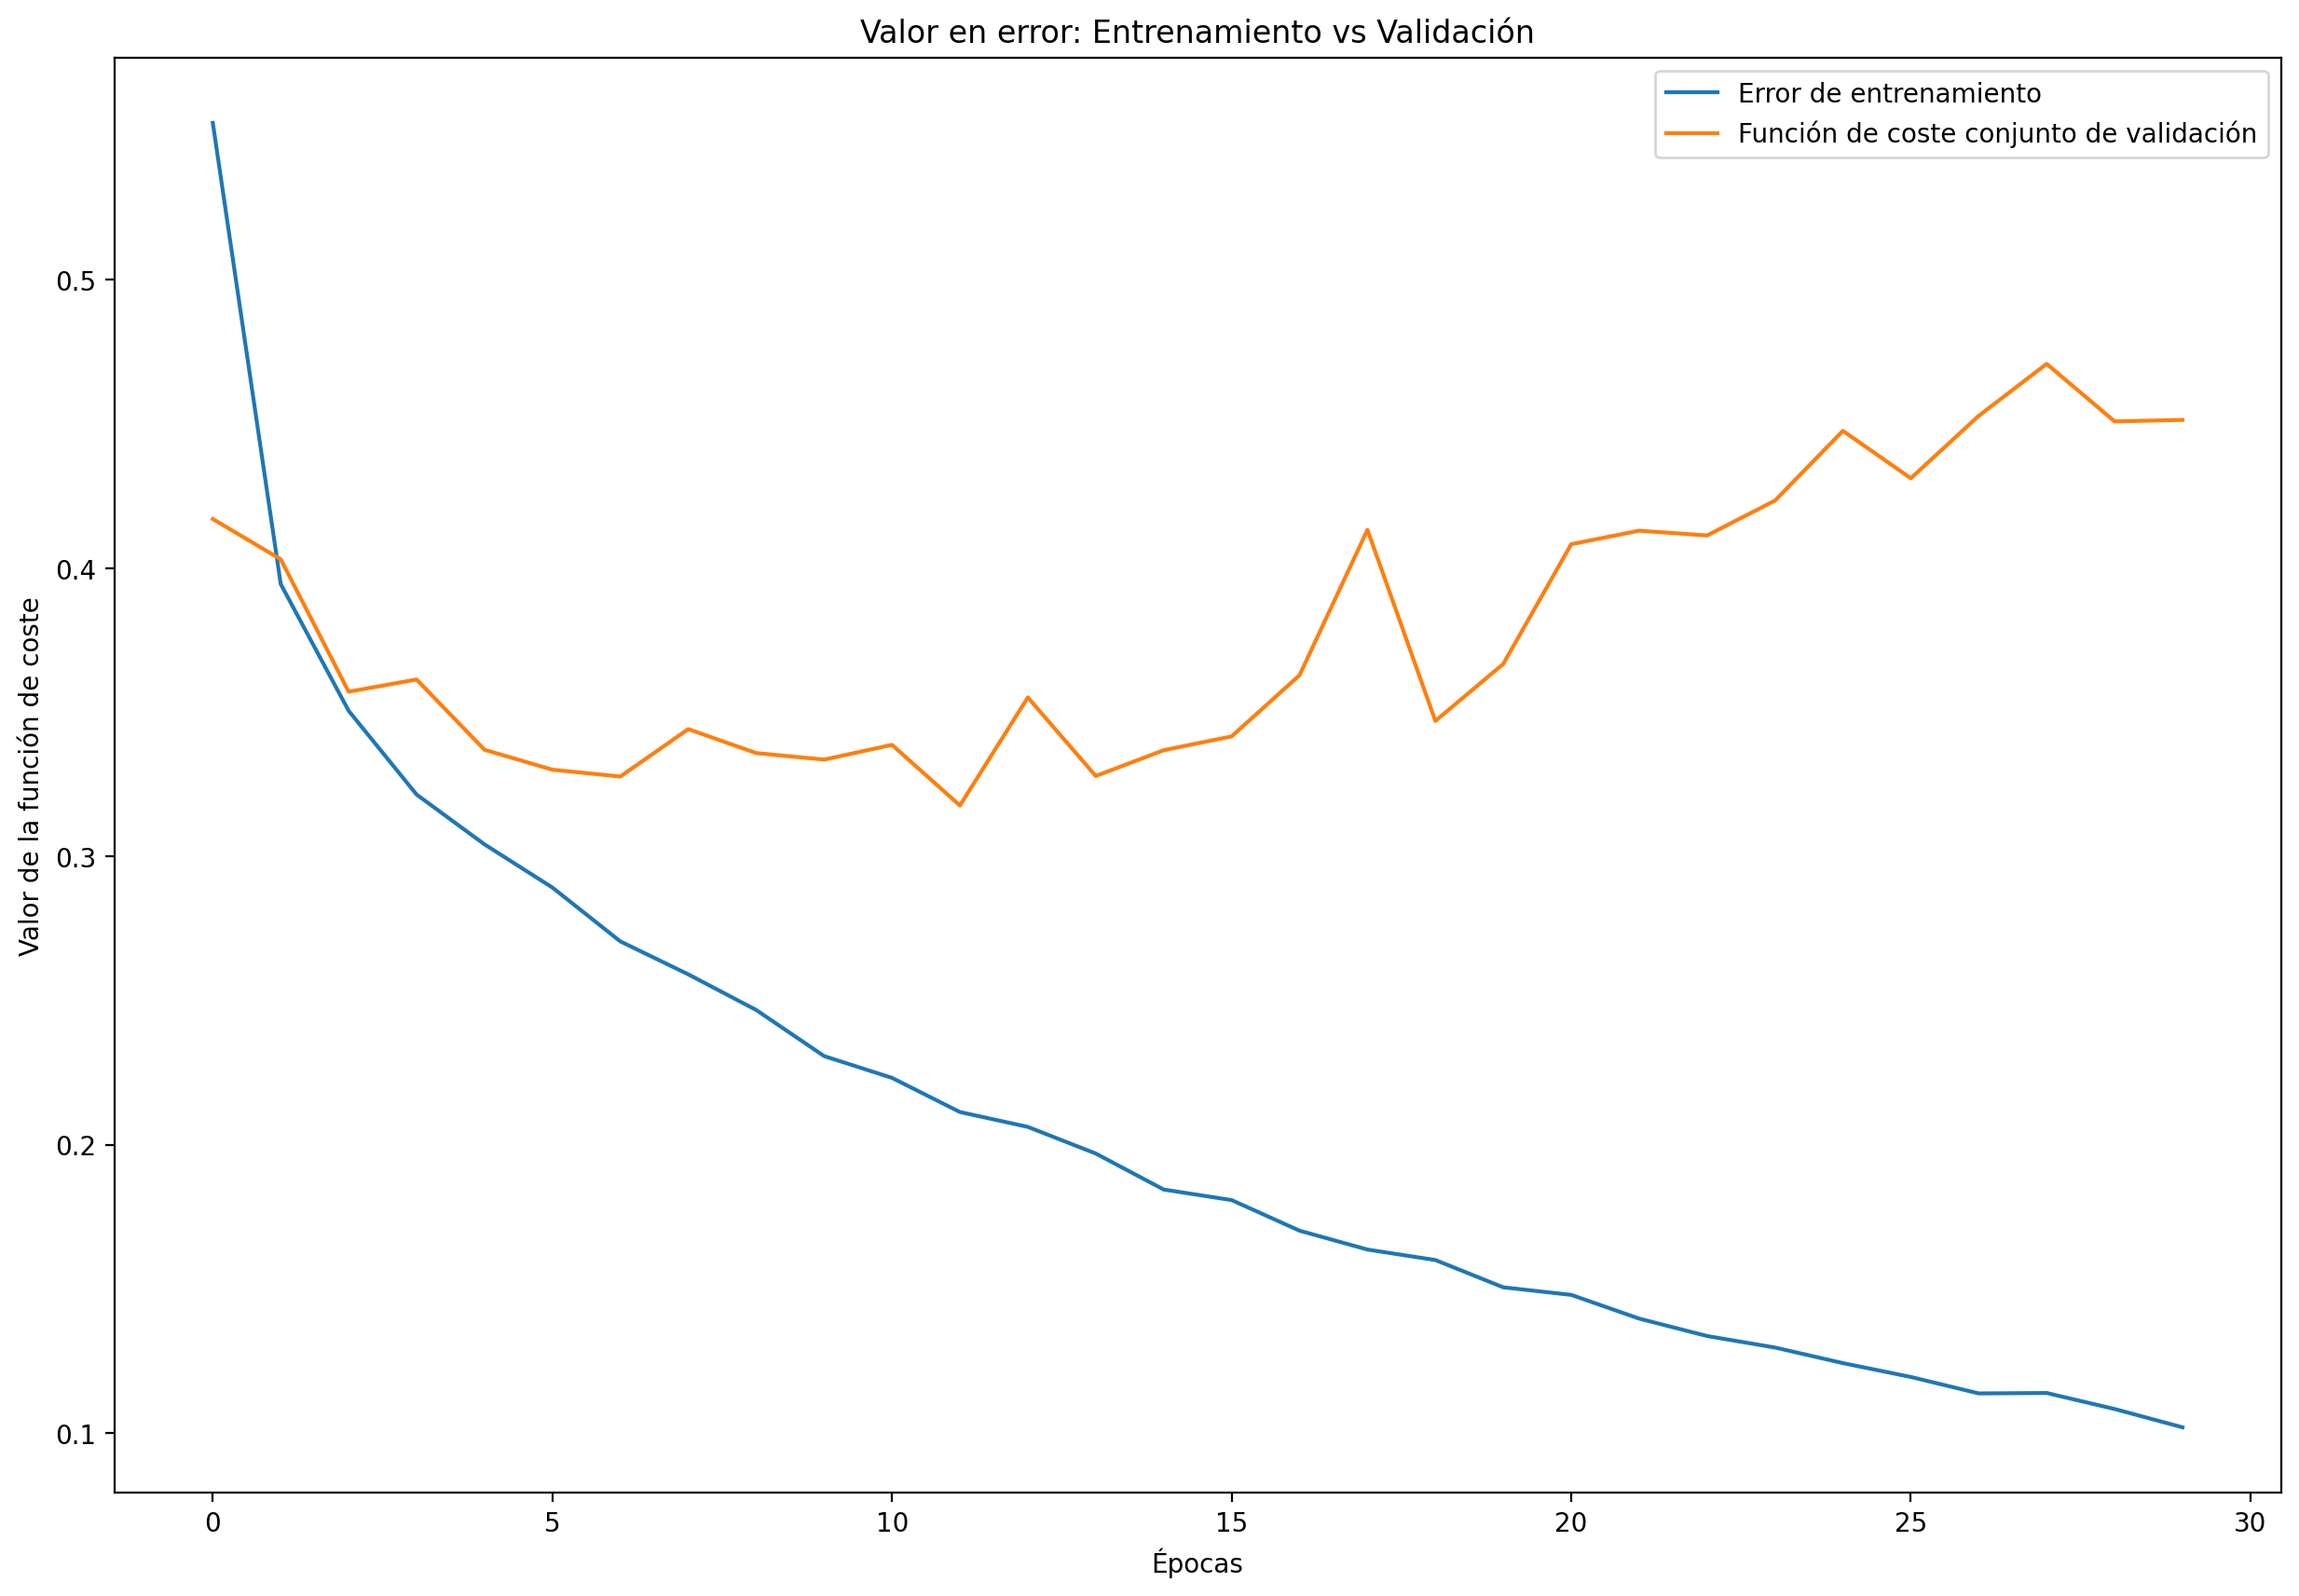

In [14]:
#YOUR CODE HERE

# Ploteamos el valor en error: Entrenamiento vs Validación
validation_cost_function = []

for i in range (30):
    validation_cost_function.append((my_MLP.valid_loss_during_training[i]).item())

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_MLP.loss_during_training, label = 'Error de entrenamiento')
ax.plot(validation_cost_function, label = 'Función de coste conjunto de validación')
ax.set_xlabel('Épocas')
ax.set_ylabel('Valor de la función de coste')
ax.set_title('Valor en error: Entrenamiento vs Validación')
ax.legend()

In [15]:
# Obtenemos el accuracy 

acurracy_train_MLP = my_MLP.acurracy_study(trainloader,my_MLP)
acurracy_test_MLP = my_MLP.acurracy_study(testloader,my_MLP)
acurracy_val_MLP = my_MLP.acurracy_study(validloader,my_MLP)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.96817297
El acurracy en el set de validación es: 0.89033693
El acurracy en el set de test es: 0.8844546


Podemos notar, especialmente al observar el gráfico, que el valor mínimo de la función de costo para el conjunto de validación se alcanza aproximadamente en la octava época. A partir de este punto, el modelo comienza a sufrir de sobreajuste en el conjunto de entrenamiento, lo que significa que ya no es capaz de generalizar adecuadamente a datos que no ha visto previamente, y su rendimiento en estos datos empeora significativamente. Esto es evidente al observar la marcada subida en la función de costo de validación a medida que aumenta el número de épocas

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [16]:
#YOUR CODE HERE

# Creamos y entrenamos el modelo utilizando early-stopping, de manera que, mirando la gráfica de arriba, observamos como debemos parar en la época 8 (aproximadamente) para evitar el overfitting
my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=8, lr=0.001 )
my_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.551582
Validation loss after 0 epochs: 0.433482

Training loss after 1 epochs: 0.394257
Validation loss after 1 epochs: 0.400654

Training loss after 2 epochs: 0.353123
Validation loss after 2 epochs: 0.366067

Training loss after 3 epochs: 0.321679
Validation loss after 3 epochs: 0.351518

Training loss after 4 epochs: 0.302327
Validation loss after 4 epochs: 0.333803

Training loss after 5 epochs: 0.285188
Validation loss after 5 epochs: 0.332233

Training loss after 6 epochs: 0.268203
Validation loss after 6 epochs: 0.330565

Training loss after 7 epochs: 0.261296
Validation loss after 7 epochs: 0.327887



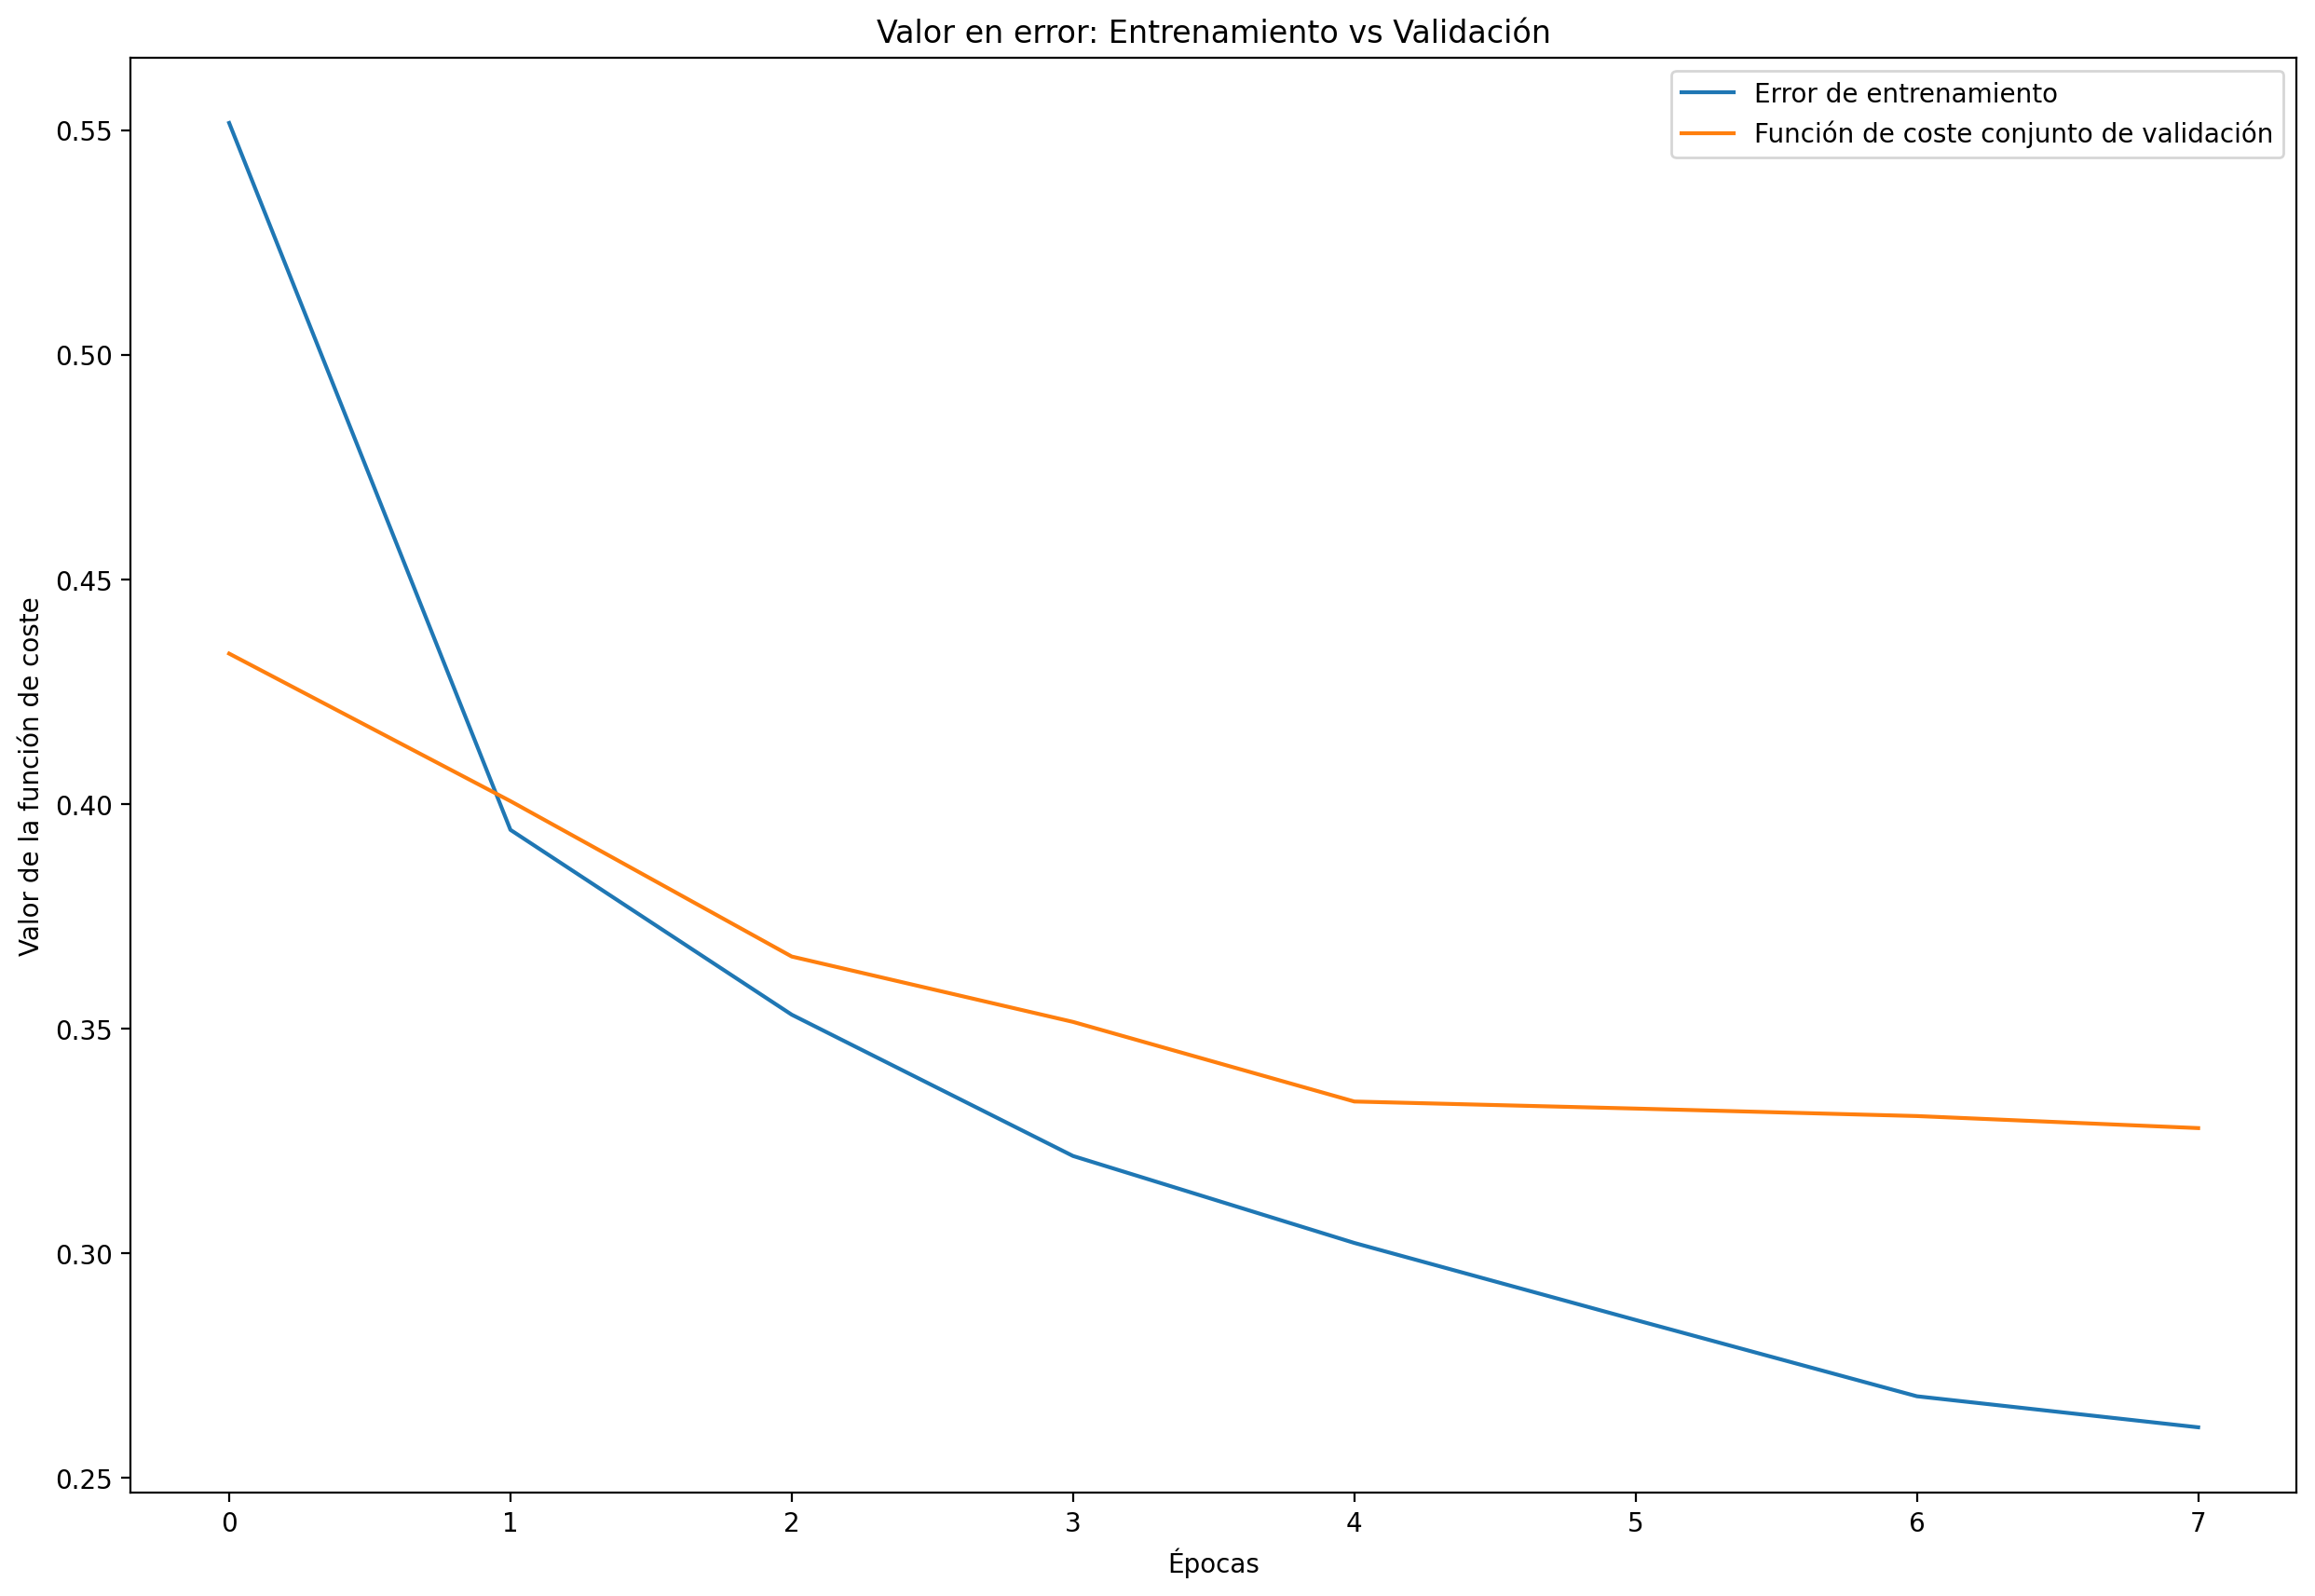

In [17]:
# Ploteamos el valor en error
validation_cost_function = []

for i in range (8):
    validation_cost_function.append((my_MLP.valid_loss_during_training[i]).item())

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_MLP.loss_during_training, label = 'Error de entrenamiento')
ax.plot(validation_cost_function, label = 'Función de coste conjunto de validación')
ax.set_xlabel('Épocas')
ax.set_ylabel('Valor de la función de coste')
ax.set_title('Valor en error: Entrenamiento vs Validación')
ax.legend()

In [18]:
# Obtenemos el accuracy de entrenamiento, validación y test

acurracy_train_MLP = my_MLP.acurracy_study(trainloader,my_MLP)
acurracy_test_MLP = my_MLP.acurracy_study(testloader,my_MLP)
acurracy_val_MLP = my_MLP.acurracy_study(validloader,my_MLP)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.9139959
El acurracy en el set de validación es: 0.8828901
El acurracy en el set de test es: 0.8759952


En el gráfico, podemos apreciar cómo detenemos el entrenamiento en un punto en el que el modelo aún no ha experimentado un sobreajuste significativo. Además, notamos que la precisión en el conjunto de entrenamiento y el conjunto de pruebas se acerca, lo que sugiere que hemos logrado reducir el sobreajuste mediante el uso de la técnica de "early-stopping".

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modify the extended class to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [19]:
class MLPdrop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)
        
        self.output3 = nn.Linear(hidden2,hidden3)

        self.output4 = nn.Linear(hidden3, nlabels) # nos piden 4 capas
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)    

        self.dropout = nn.Dropout(p_dropout) # droput con una probabilidad de 0.2                                                         
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x) # introducimos tras la función de activación 
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x) 
        return x

In [20]:
#YOUR CODE HERE

class MLPdrop_extended(MLPdrop):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,p_dropout)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # loss en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            self.train() # ya que vamos a entrenar el modelo y queremos aplicar dropout

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))

                #Your code here (multiple lines)
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # no grads

                self.eval() # desactivamos el droput para el test del conjunto de evaluación

                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
               
                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) 

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
                print('')

    def acurracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            self.eval()
            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        #print("Test Accuracy %f" %(accuracy/len(loader)))

        return ((accuracy/len(loader)).numpy().max())

In [21]:
 
my_MLP_dropout = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10,p_dropout=0.2 , epochs=30, lr=0.001 )
my_MLP_dropout.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.633902
Validation loss after 0 epochs: 0.493651

Training loss after 1 epochs: 0.454475
Validation loss after 1 epochs: 0.429218

Training loss after 2 epochs: 0.414385
Validation loss after 2 epochs: 0.412594

Training loss after 3 epochs: 0.382070
Validation loss after 3 epochs: 0.372480

Training loss after 4 epochs: 0.366566
Validation loss after 4 epochs: 0.371436

Training loss after 5 epochs: 0.353166
Validation loss after 5 epochs: 0.336108

Training loss after 6 epochs: 0.341658
Validation loss after 6 epochs: 0.349242

Training loss after 7 epochs: 0.335075
Validation loss after 7 epochs: 0.345100

Training loss after 8 epochs: 0.318309
Validation loss after 8 epochs: 0.340788

Training loss after 9 epochs: 0.308660
Validation loss after 9 epochs: 0.330233

Training loss after 10 epochs: 0.306156
Validation loss after 10 epochs: 0.336006

Training loss after 11 epochs: 0.292267
Validation loss after 11 epochs: 0.317742

Training loss after 12 e

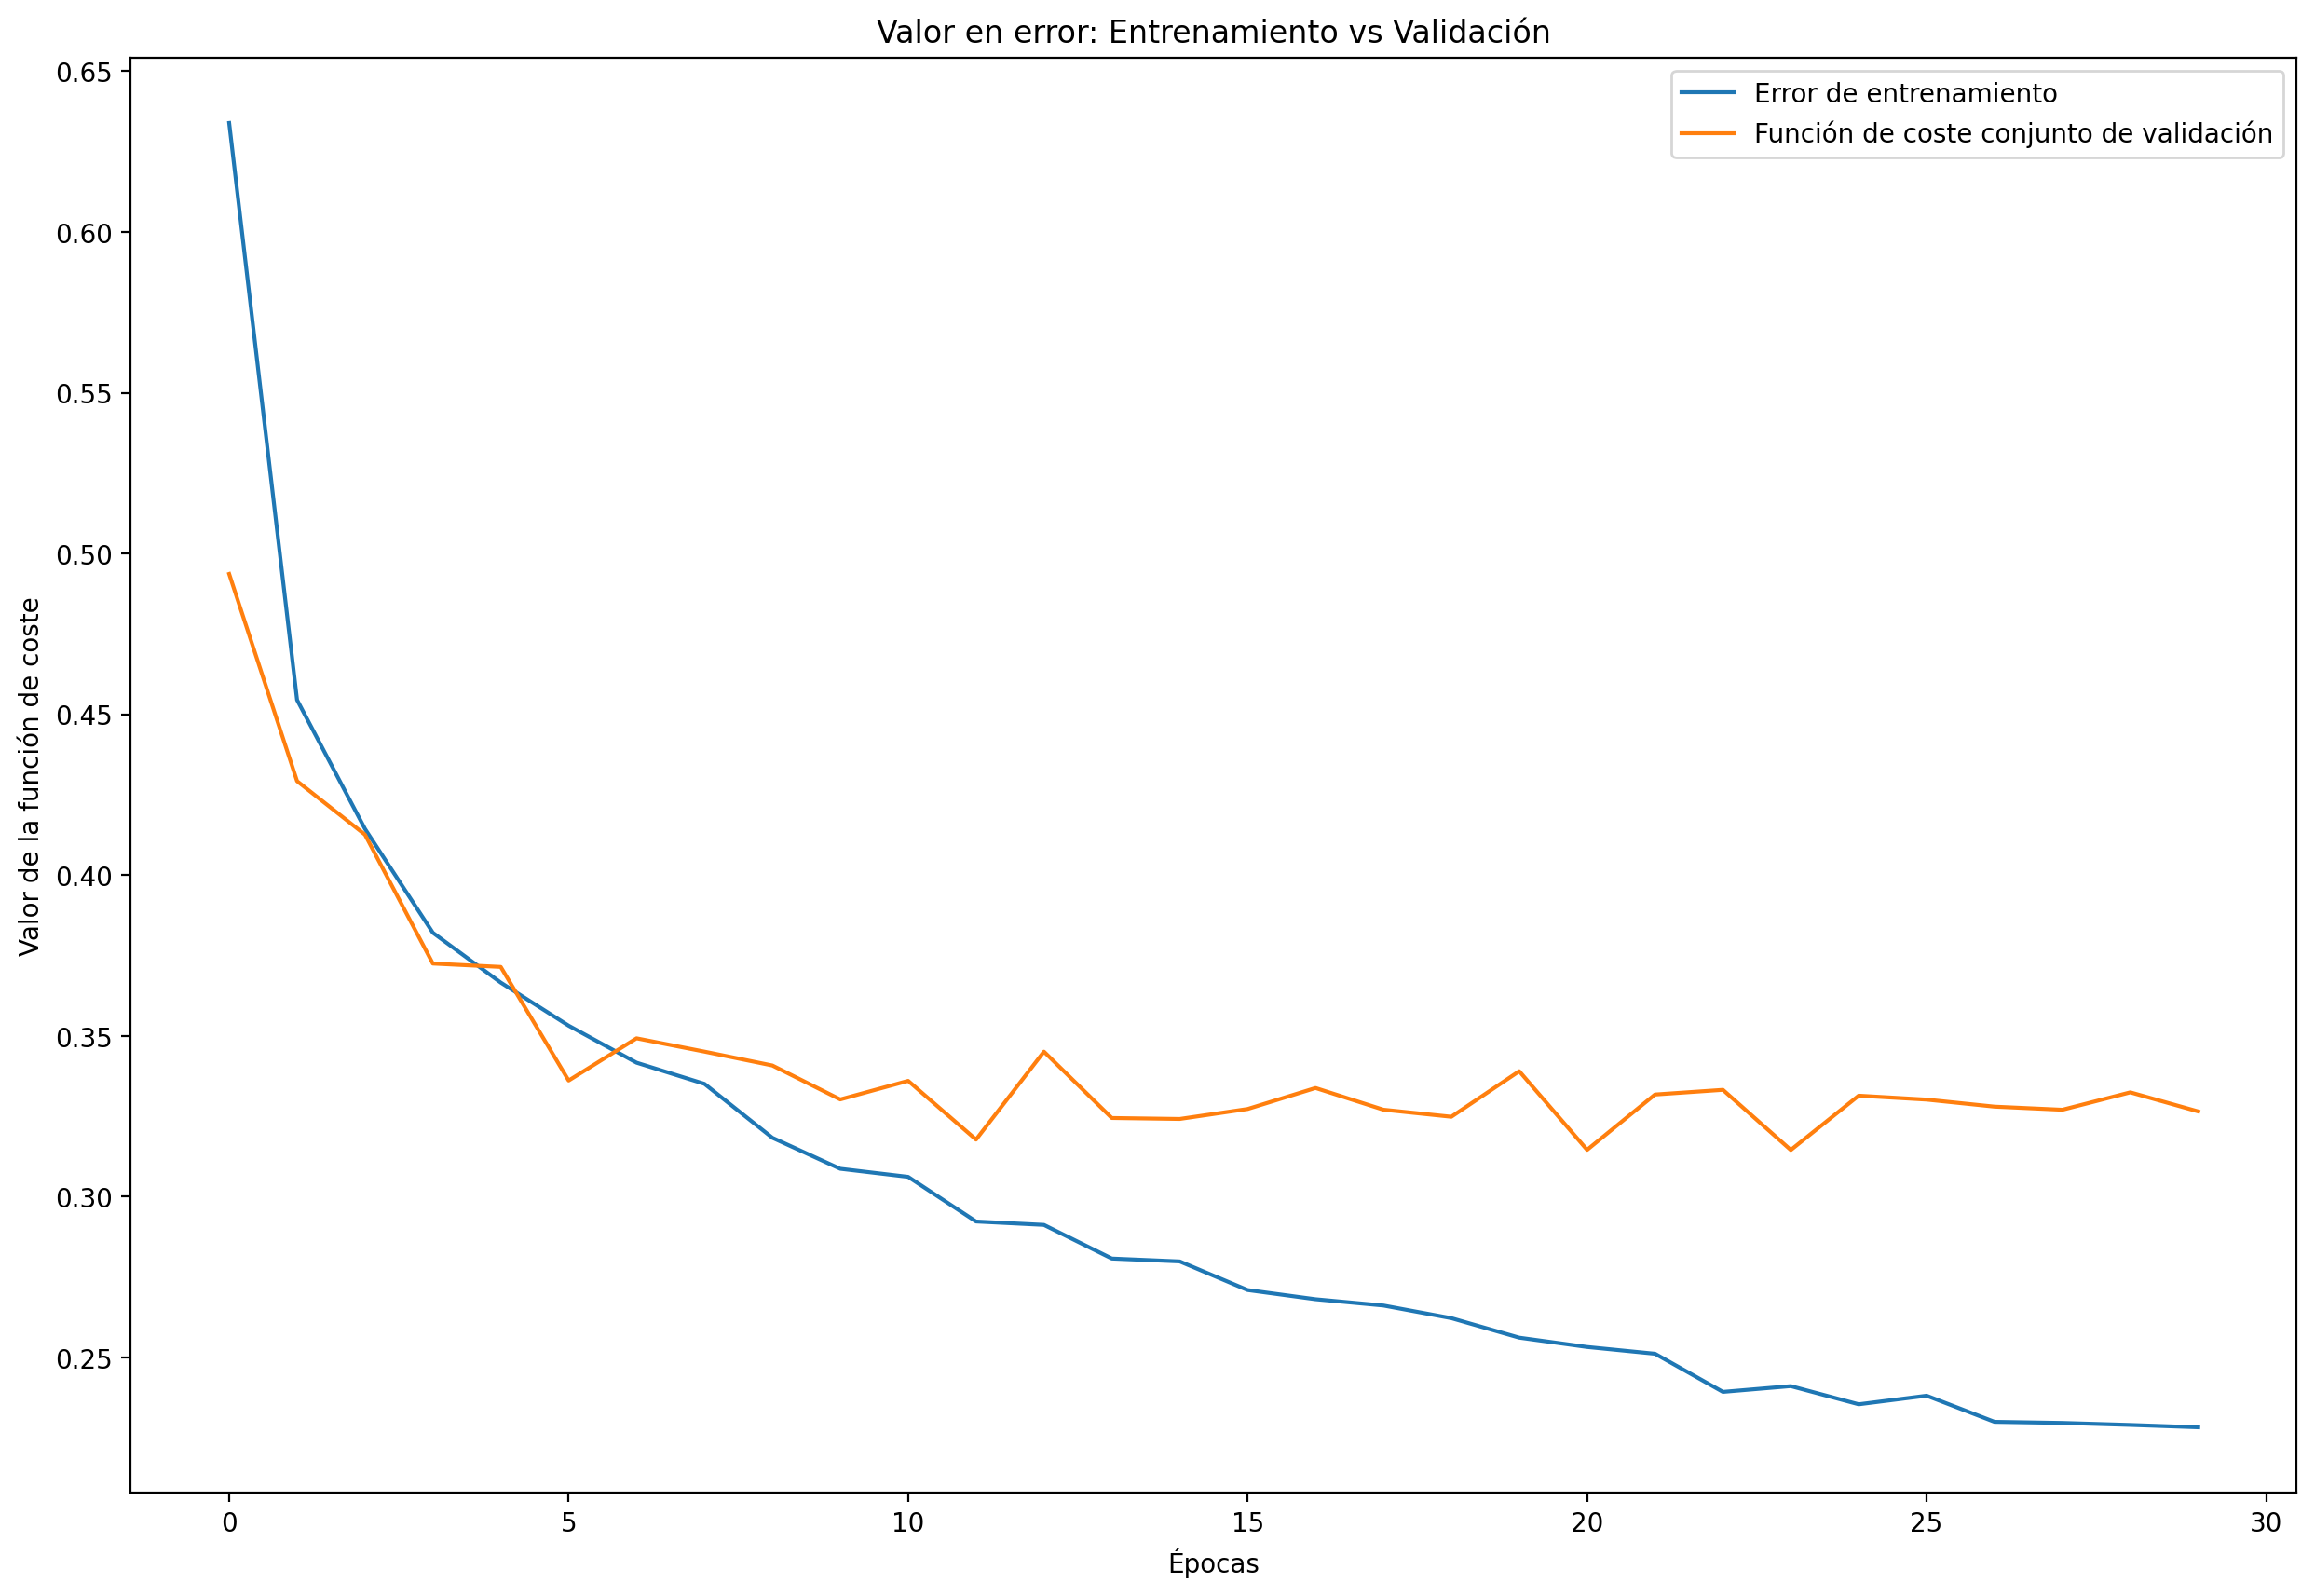

In [22]:
# Ploteamos el valor en error: Entrenamiento vs Validación
validation_cost_function = []

for i in range (30):
    validation_cost_function.append((my_MLP_dropout.valid_loss_during_training[i]).item())

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_MLP_dropout.loss_during_training, label = 'Error de entrenamiento')
ax.plot(validation_cost_function, label = 'Función de coste conjunto de validación')
ax.set_xlabel('Épocas')
ax.set_ylabel('Valor de la función de coste')
ax.set_title('Valor en error: Entrenamiento vs Validación')
ax.legend()

In [23]:
# Obtenemos el accuracy de entrenamiento, validación y test

acurracy_train_MLP = my_MLP_dropout.acurracy_study(trainloader,my_MLP_dropout)
acurracy_test_MLP = my_MLP_dropout.acurracy_study(testloader,my_MLP_dropout)
acurracy_val_MLP = my_MLP_dropout.acurracy_study(validloader,my_MLP_dropout)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.93556905
El acurracy en el set de validación es: 0.889539
El acurracy en el set de test es: 0.88783836


Podemos observar una clara diferencia en comparación con el escenario en el que solo utilizamos "early-stopping". En este caso, el conjunto de validación muestra una marcada desaceleración en su tasa de decrecimiento y se mantiene más o menos constante, con ciertos picos ocasionados por las variaciones de los gradientes entre épocas. Al menos, no comienza a aumentar de manera exagerada debido al sobreajuste, lo que indica una reducción del mismo (esto se confirma al examinar la mejora en la precisión final, ya que los valores de entrenamiento y test se acercan entre sí). Sin embargo, aún persiste cierto grado de sobreajuste, ya que, aunque la tasa de decrecimiento se estabiliza, la validación deja de disminuir. En este caso, podríamos aplicar la técnica de "early-stopping" aproximadamente en la época 12, que es donde se alcanza el mínimo valor de la función de costo en el conjunto de validación.

para p=0.1 y p=0.3

In [24]:

my_MLP_dropout = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10,p_dropout=0.1 , epochs=30, lr=0.001 )
my_MLP_dropout.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.589657
Validation loss after 0 epochs: 0.429672

Training loss after 1 epochs: 0.423416
Validation loss after 1 epochs: 0.418351

Training loss after 2 epochs: 0.380456
Validation loss after 2 epochs: 0.376690

Training loss after 3 epochs: 0.356998
Validation loss after 3 epochs: 0.370407

Training loss after 4 epochs: 0.338869
Validation loss after 4 epochs: 0.347189

Training loss after 5 epochs: 0.324045
Validation loss after 5 epochs: 0.351226

Training loss after 6 epochs: 0.308938
Validation loss after 6 epochs: 0.339210

Training loss after 7 epochs: 0.298371
Validation loss after 7 epochs: 0.338498

Training loss after 8 epochs: 0.287151
Validation loss after 8 epochs: 0.349932

Training loss after 9 epochs: 0.276208
Validation loss after 9 epochs: 0.324142

Training loss after 10 epochs: 0.267434
Validation loss after 10 epochs: 0.332881

Training loss after 11 epochs: 0.259912
Validation loss after 11 epochs: 0.327822

Training loss after 12 e

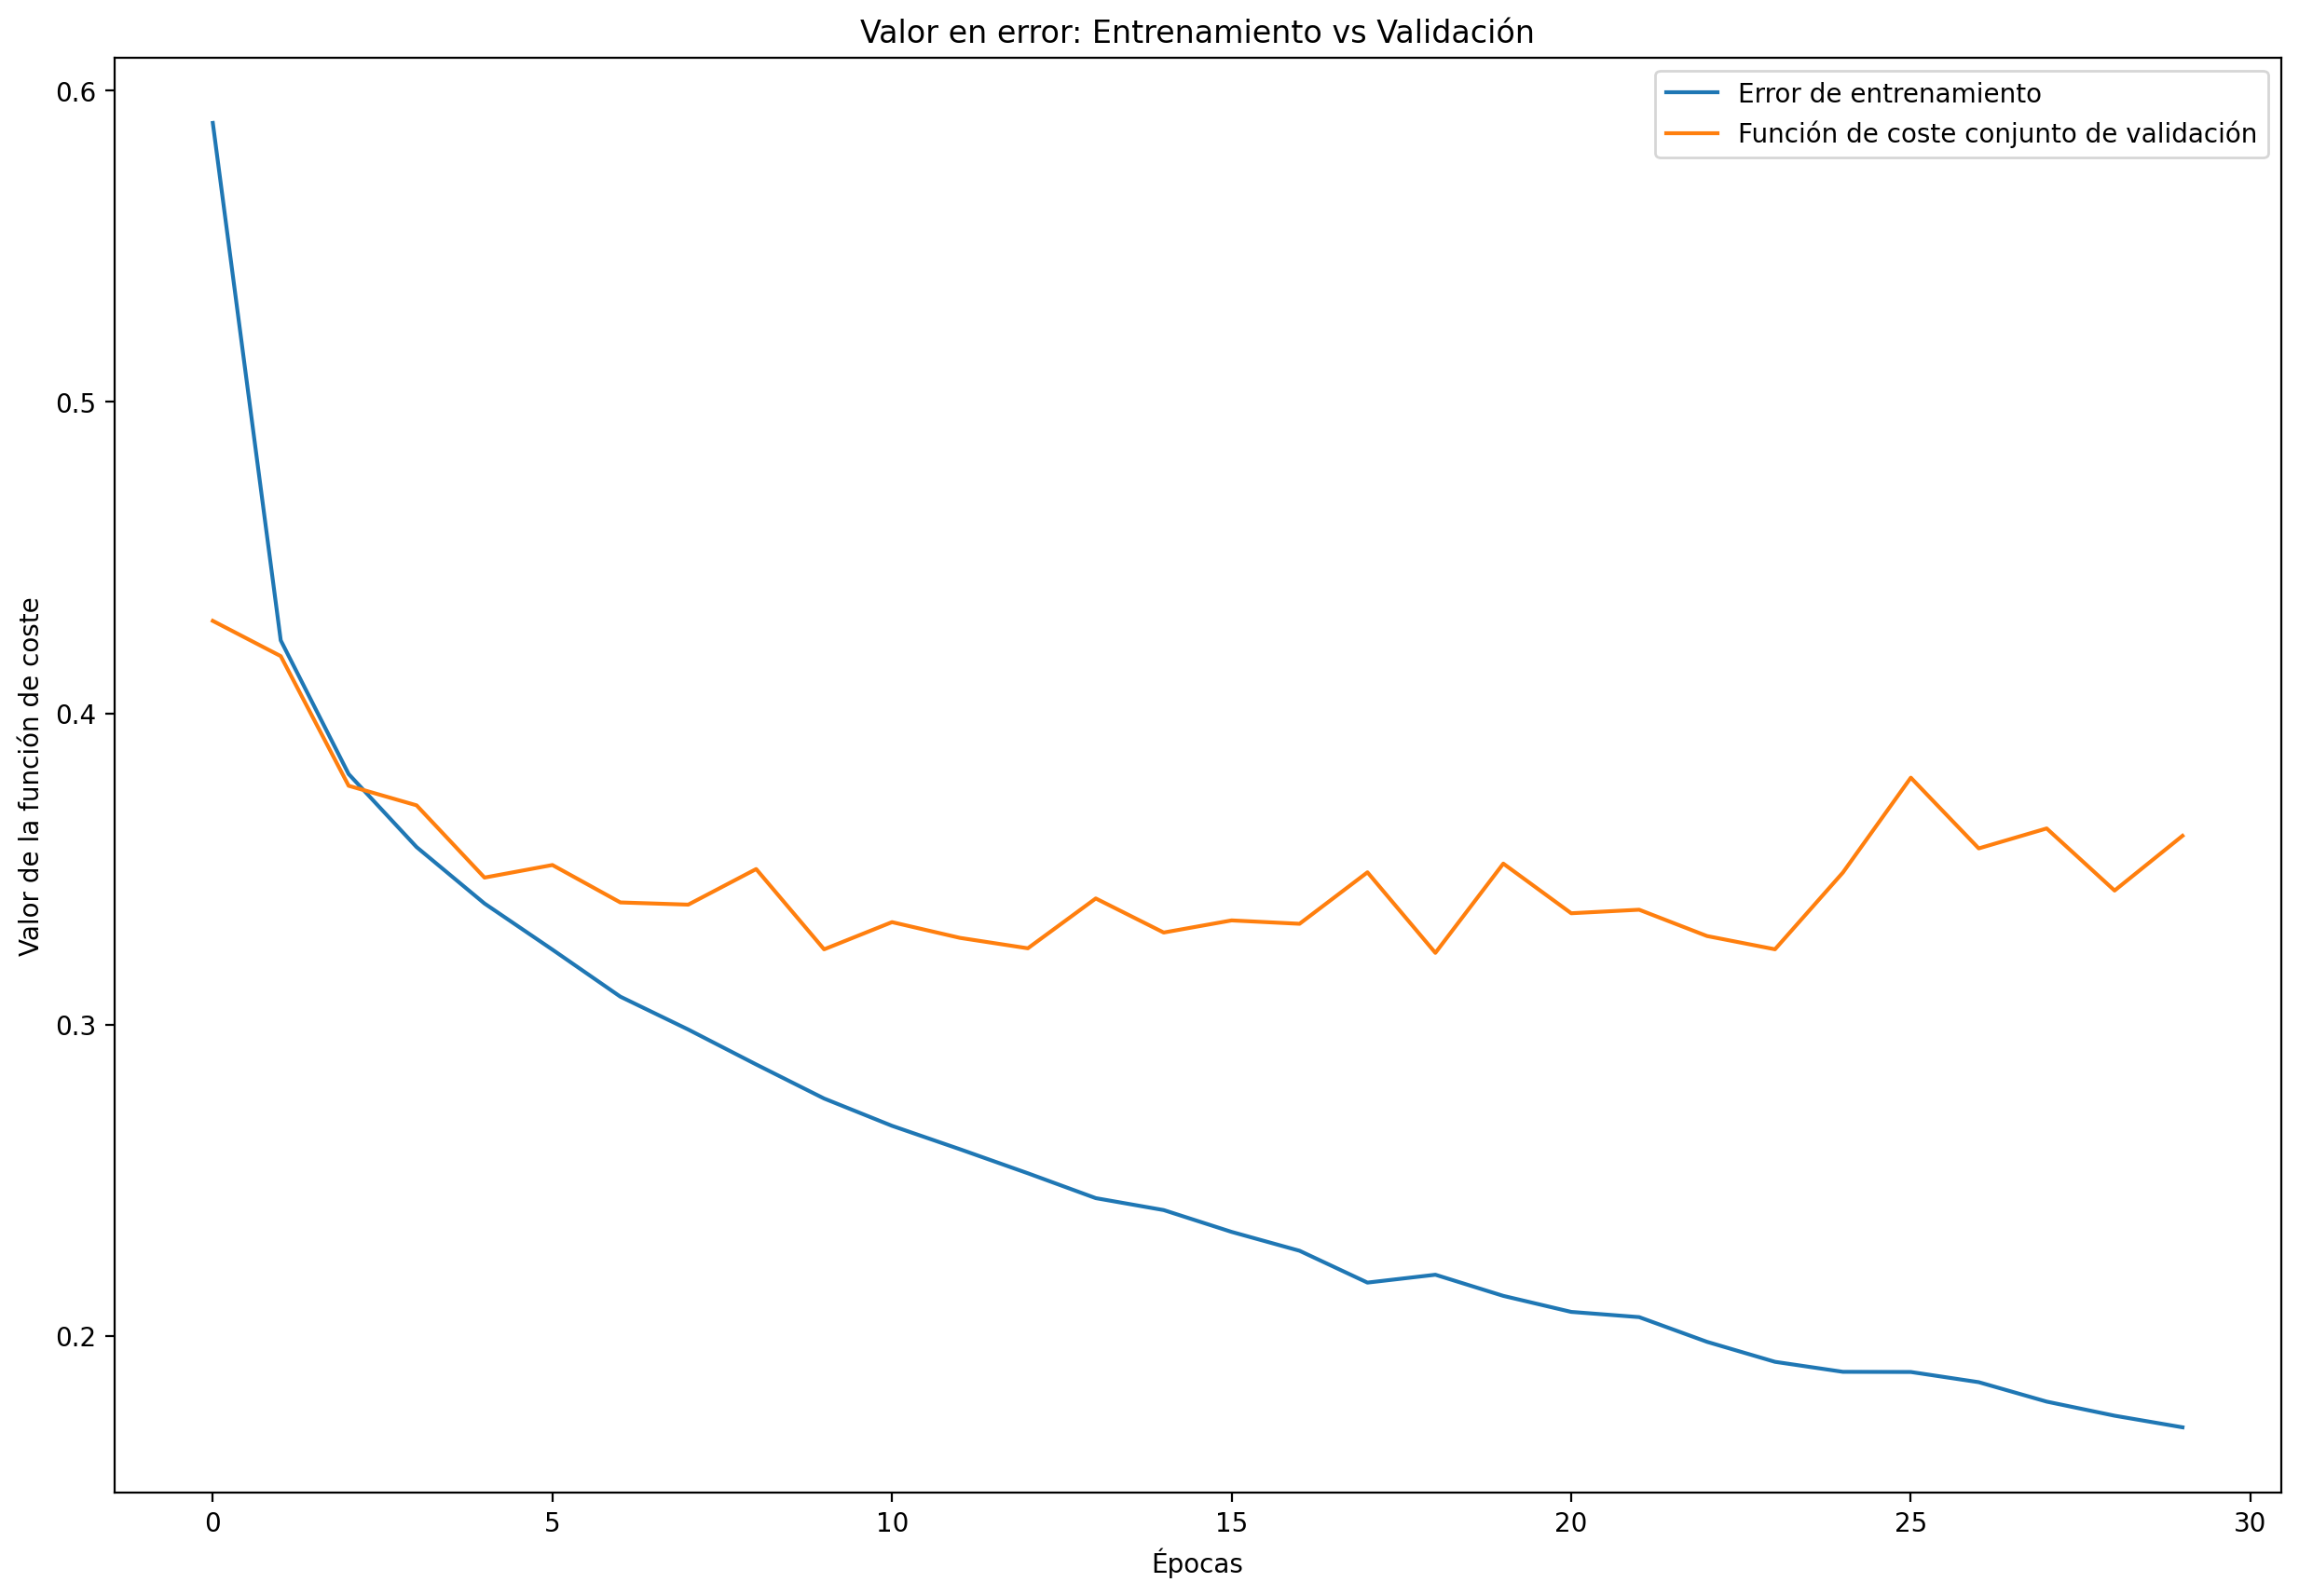

In [25]:

validation_cost_function = []

for i in range (30):
    validation_cost_function.append((my_MLP_dropout.valid_loss_during_training[i]).item())

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_MLP_dropout.loss_during_training, label = 'Error de entrenamiento')
ax.plot(validation_cost_function, label = 'Función de coste conjunto de validación')
ax.set_xlabel('Épocas')
ax.set_ylabel('Valor de la función de coste')
ax.set_title('Valor en error: Entrenamiento vs Validación')
ax.legend()

In [26]:


acurracy_train_MLP = my_MLP_dropout.acurracy_study(trainloader,my_MLP_dropout)
acurracy_test_MLP = my_MLP_dropout.acurracy_study(testloader,my_MLP_dropout)
acurracy_val_MLP = my_MLP_dropout.acurracy_study(validloader,my_MLP_dropout)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.9464666
El acurracy en el set de validación es: 0.89058065
El acurracy en el set de test es: 0.8858479


Podemos notar un deterioro en el rendimiento general del modelo. Debido a la probabilidad más baja de dropout, este fenómeno ocurre con menor frecuencia, lo que a su vez conduce a un aumento del sobreajuste. Este incremento se evidencia tanto en el gráfico, donde la curva de validación muestra un aumento a lo largo de las épocas, como en la métrica de precisión, ya que los valores de entrenamiento y prueba comienzan a distanciarse. Sin embargo, es importante destacar que, a pesar de este efecto adverso, el resultado es significativamente mejor en comparación con el escenario en el que no se utilizaba dropout.

In [27]:
# Realizamos el mismo experimento con p=0.3
my_MLP_dropout = MLPdrop_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10,p_dropout=0.3 , epochs=30, lr=0.001 )
my_MLP_dropout.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.689532
Validation loss after 0 epochs: 0.465229

Training loss after 1 epochs: 0.492690
Validation loss after 1 epochs: 0.429474

Training loss after 2 epochs: 0.450077
Validation loss after 2 epochs: 0.416880

Training loss after 3 epochs: 0.420980
Validation loss after 3 epochs: 0.371988

Training loss after 4 epochs: 0.398576
Validation loss after 4 epochs: 0.375949

Training loss after 5 epochs: 0.386339
Validation loss after 5 epochs: 0.357243

Training loss after 6 epochs: 0.372973
Validation loss after 6 epochs: 0.344138

Training loss after 7 epochs: 0.366633
Validation loss after 7 epochs: 0.345568

Training loss after 8 epochs: 0.353288
Validation loss after 8 epochs: 0.349229

Training loss after 9 epochs: 0.348529
Validation loss after 9 epochs: 0.346621

Training loss after 10 epochs: 0.341910
Validation loss after 10 epochs: 0.338878

Training loss after 11 epochs: 0.334952
Validation loss after 11 epochs: 0.332795

Training loss after 12 e

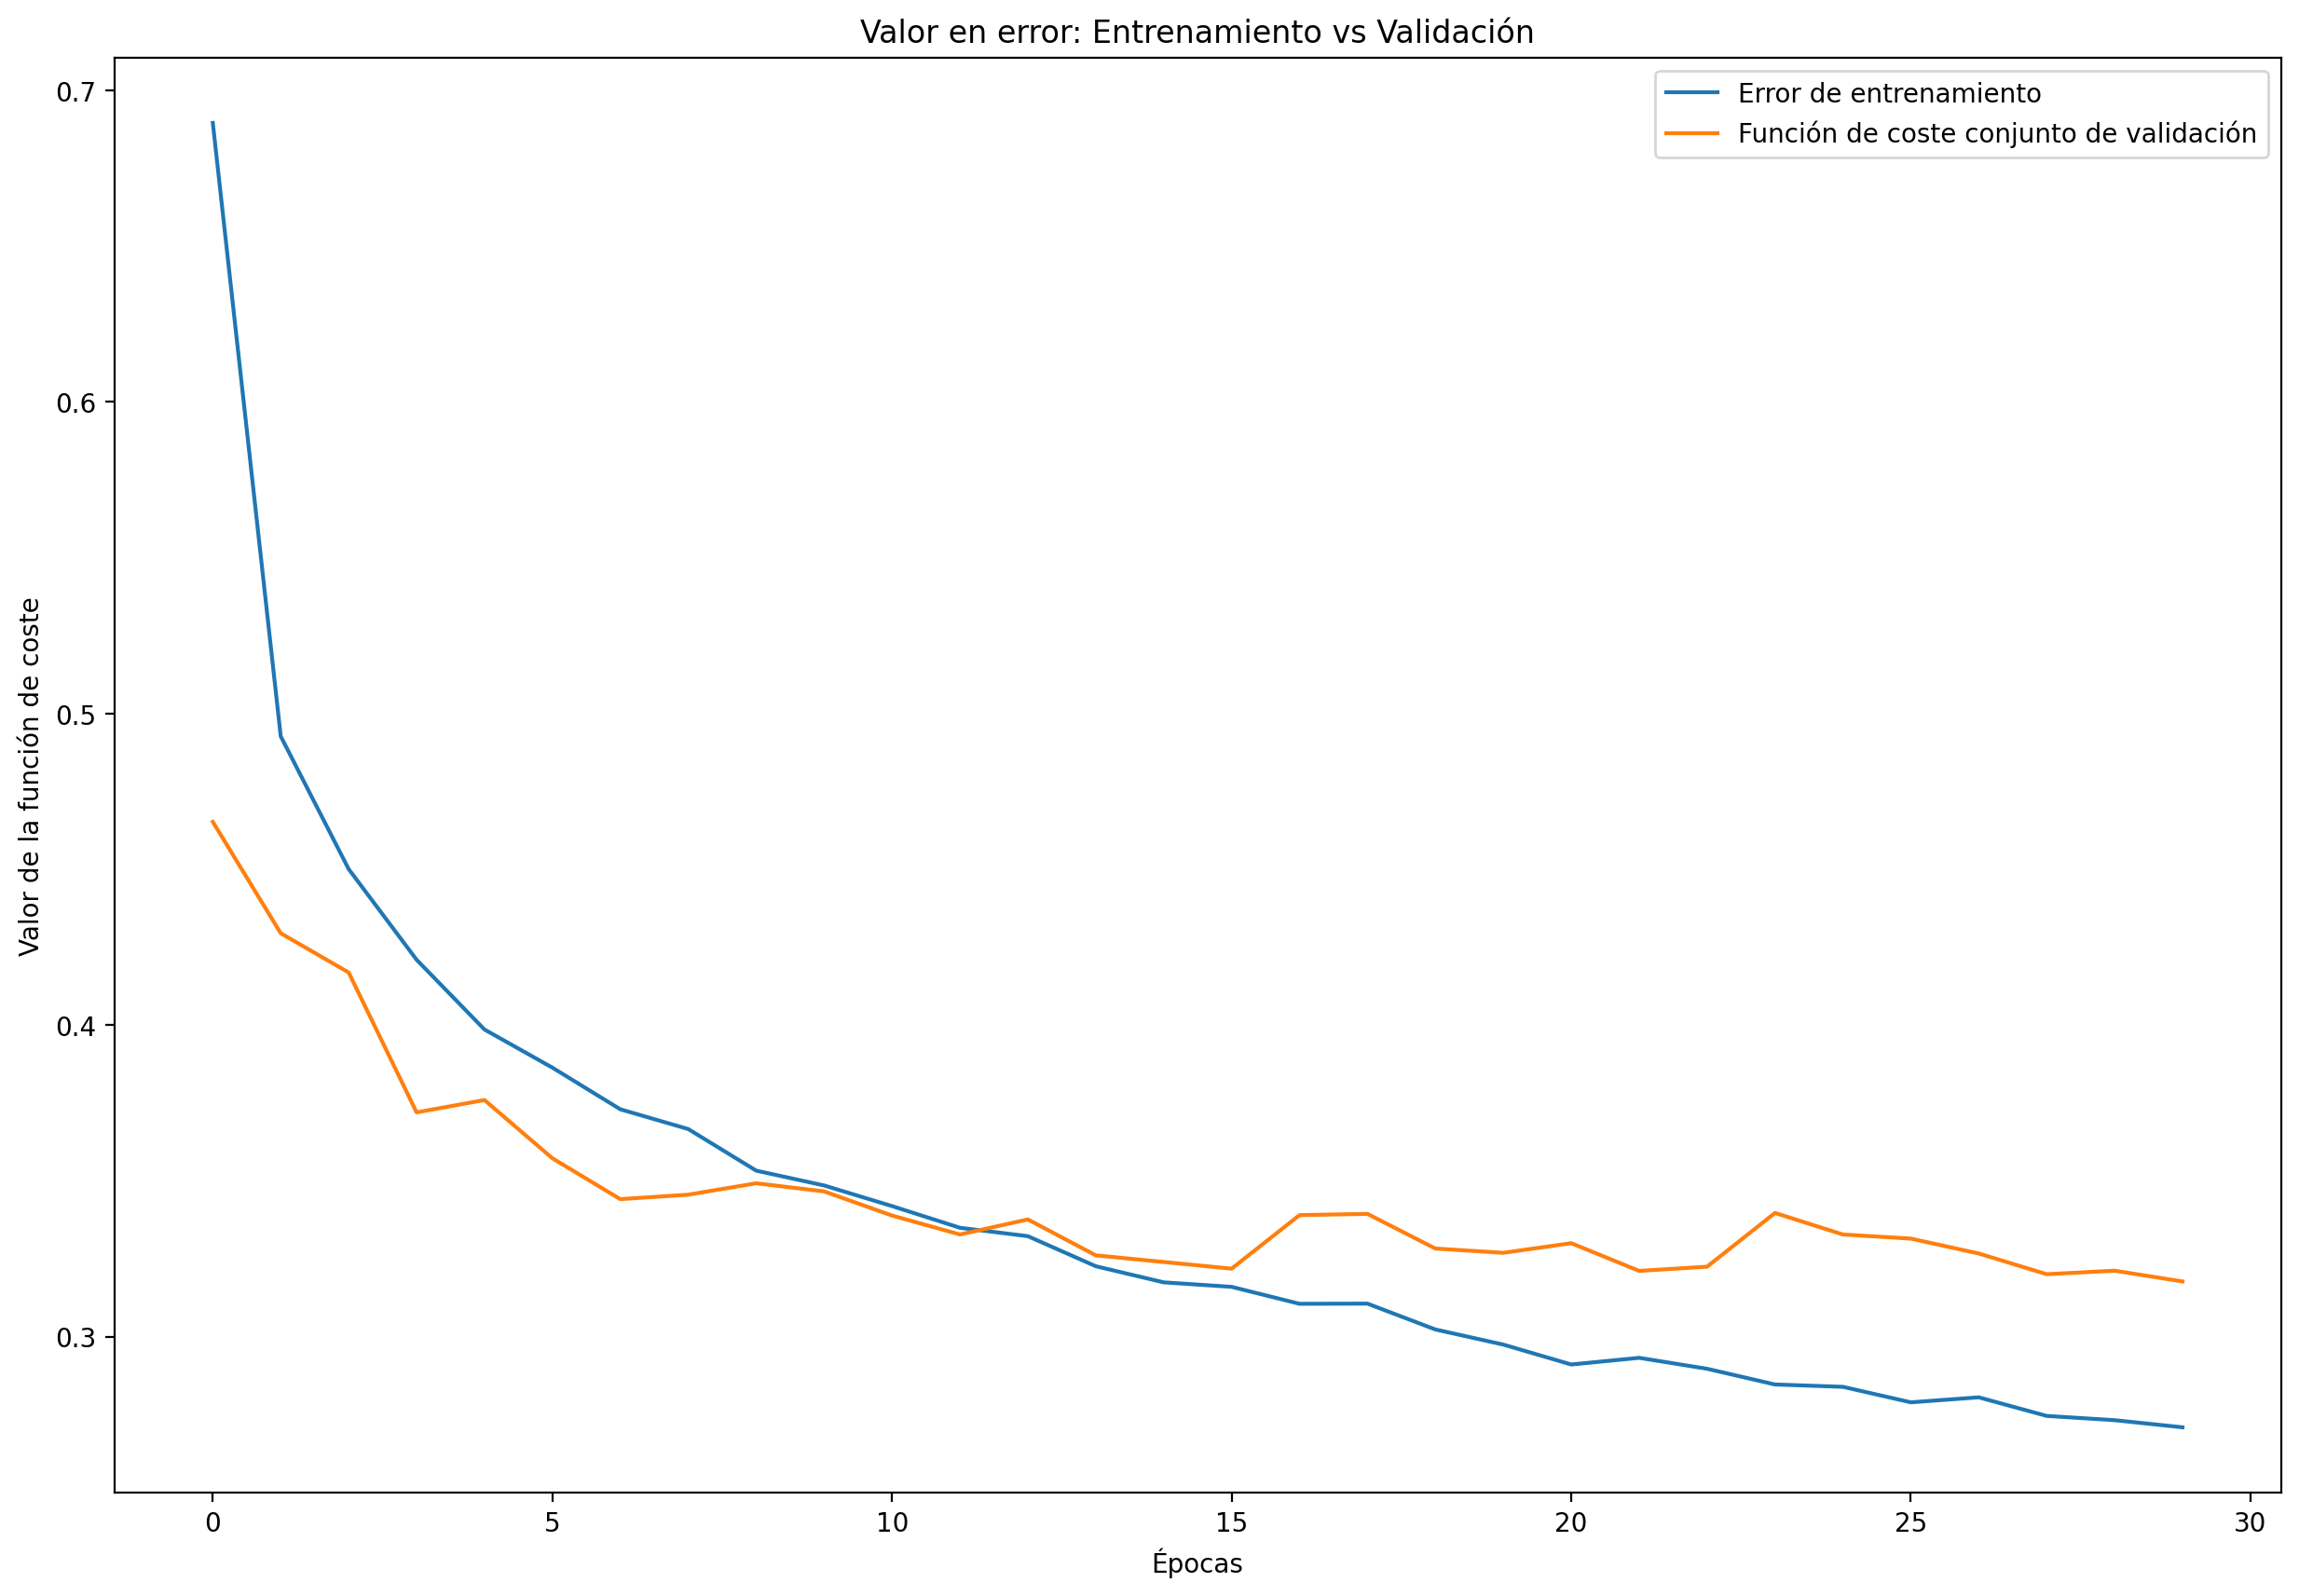

In [28]:

validation_cost_function = []

for i in range (30):
    validation_cost_function.append((my_MLP_dropout.valid_loss_during_training[i]).item())

fig, ax = plt.subplots(figsize = (15,10))
ax.plot(my_MLP_dropout.loss_during_training, label = 'Error de entrenamiento')
ax.plot(validation_cost_function, label = 'Función de coste conjunto de validación')
ax.set_xlabel('Épocas')
ax.set_ylabel('Valor de la función de coste')
ax.set_title('Valor en error: Entrenamiento vs Validación')
ax.legend()

In [29]:


acurracy_train_MLP = my_MLP_dropout.acurracy_study(trainloader,my_MLP_dropout)
acurracy_test_MLP = my_MLP_dropout.acurracy_study(testloader,my_MLP_dropout)
acurracy_val_MLP = my_MLP_dropout.acurracy_study(validloader,my_MLP_dropout)

print('El acurracy en el set de entrenamiento es: ' + str(acurracy_train_MLP))
print('El acurracy en el set de validación es: ' + str(acurracy_val_MLP))
print('El acurracy en el set de test es: ' + str(acurracy_test_MLP))

El acurracy en el set de entrenamiento es: 0.9229847
El acurracy en el set de validación es: 0.88761085
El acurracy en el set de test es: 0.8809713


Al aumentar la probabilidad de dropout, estamos provocando que este evento ocurra con mayor frecuencia, lo que a su vez contribuye a reducir el sobreajuste. Aunque a nivel gráfico observamos una mejora significativa, dado que la curva de validación no deja de disminuir, lo que indica una disminución en el sobreajuste y que la red neuronal ya no se ajusta excesivamente al conjunto de entrenamiento, en cuanto a la métrica de precisión final, el resultado es mejor que en el caso con una probabilidad de dropout de 0.2. Sin embargo, la diferencia no es tan marcada en comparación con el cambio de p=0.2 a p=0.1, donde la mejora era mucho más notable.

En resumen, este modelo final demuestra un mejor rendimiento en términos generales y parece ser la opción óptima.